In [ ]:
#@title Imports
import torch
import torch.nn.functional as F
import math
import torch.nn as nn
from transformers import GPT2Config, GPT2Model
from transformers.models.gpt2.modeling_gpt2 import ACT2FN

from tqdm.auto import tqdm
import wandb
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title Utilities
import os
import torch

try:
    # In Colab, this will import drive; if you're not on Colab you can omit or replace this.
    from google.colab import drive
    _COLAB = True
except ImportError:
    _COLAB = False

def save_model(model: torch.nn.Module,
                         folder: str,
                         filename: str,
                         mount_point: str = '/content/drive'):
    """
    Saves model.state_dict() into Google Drive.

    Args:
        model:        your torch.nn.Module
        gdrive_folder: path inside "My Drive" (e.g. 'models/checkpoints')
        filename:     filename to save as (e.g. 'resnet50.pth')
        mount_point:  where Drive is mounted (Colab default '/content/drive')
    """
    # 1. Mount Drive if needed
    if _COLAB and not os.path.exists(mount_point):
        drive.mount(mount_point)

    # 2. Build the full path under "My Drive"
    full_folder = os.path.join(mount_point, 'My Drive', folder)
    os.makedirs(full_folder, exist_ok=True)

    # 3. Save the state dict
    target_path = os.path.join(full_folder, filename)
    torch.save(model.state_dict(), target_path)

    print(f"[✅] Saved state_dict to {target_path}")
print(_COLAB)
drive.mount('/content/drive')

True
Mounted at /content/drive


In [ ]:
#@title Data Generation
def generate_sine_batch(
    batch_size: int,
    grid_len: int,
    rand_len: int,
    num_sines: int = 16,
    domain=(0.0, 1.0), # period
    random_domain_factor: int = 2,
    device=torch.device('cuda'),
):
    """
    Returns a batch of interleaved [t, f(t)] sequences, all generated on `device`.

    - grid_len:               number of evenly spaced t’s (torch.linspace over domain)
    - rand_len:               number of additional random t’s per sample (uniform over domain)
    - num_sines:              number of sine components (frequencies 1..num_sines)
    - domain:                 (t_min, t_max) should be the length of one period
    - random_domain_factor:   number of periods to sample over
    """
    t_min, t_max = domain

    t_base = torch.linspace(t_min, t_max, steps=grid_len, device=device)
    rand_mat = torch.rand(batch_size, grid_len, device=device)
    perms   = rand_mat.argsort(dim=1)

    # 1) make the grid ts: shape (1, grid_len) -> expand to (batch_size, grid_len)
    t_grid = t_base.unsqueeze(0).expand(batch_size, -1)
    t_grid = t_grid.gather(1, perms)

    # 2) make the random ts: shape (batch_size, rand_len)
    # t_rand = torch.rand(batch_size, rand_len, device=device) * random_domain_factor * (t_max - t_min) + t_min # uniform random sampling
    t_rand = torch.randn(batch_size, rand_len, device=device) * 1 + 1 # normal random sampling with mu = 1, stdev = 1,

    # 3) concat to get all ts: shape (batch_size, total_len)
    t_all = torch.cat([t_grid, t_rand], dim=1)
    total_len = grid_len + rand_len

    # 4) prepare your sine parameters on GPU:
    #    freqs = [[1,2,3,...,num_sines]] for each batch
    freqs  = 2 * torch.pi * torch.arange(1, num_sines+1, device=device) \
                   .unsqueeze(0) \
                   .expand(batch_size, num_sines)
    #    phases = 0 or π/2 at random
    phases = torch.randint(0, 2, (batch_size, num_sines), device=device) \
                   .to(torch.float) * (math.pi/2)
    #    amplitudes still random in [0,1)
    amps    = torch.rand(batch_size, num_sines, device=device)

    # 5) compute each wave over all ts:
    #    expand t_all to (batch_size, 1, total_len) so it broadcasts
    t_exp = t_all.unsqueeze(1)                     # (B, 1, L)
    arg   = freqs.unsqueeze(-1) * t_exp + phases.unsqueeze(-1)  # (B, S, L)
    waves = amps.unsqueeze(-1) * torch.sin(arg)    # (B, S, L)

    # 6) sum over the S sines → (batch_size, total_len)
    f_all = waves.sum(dim=1)

    # 7) interleave t and f(t): stack→(B, L, 2) then flatten → (B, 2*L)
    interleaved = torch.stack([t_all, f_all], dim=-1)  # (B, L, 2)
    return interleaved.view(batch_size, total_len * 2)


In [ ]:
#@title Model Definition
import torch
import torch.nn as nn
from transformers import GPT2Config, GPT2Model

### Defaults are equivalent to 'standard' in Garg et al.

class GPT2Regressor(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int = 1,
        hidden_dim: int = 256,
        num_layers: int = 12,
        num_heads: int = 8,
        # vocab_size: int = 1,
        max_seq_len: int = 128,
        dropout: float = 0.0,
        activation_fn: str = None,
    ):
        """
        Args:
            input_dim:    dimensionality D of each real-valued input vector.
            output_dim:   dimensionality of each real-valued output (defaults to a scalar).
            hidden_dim:   GPT embedding size (n_embd).
            num_layers:   number of transformer blocks.
            num_heads:    number of attention heads.
            vocab_size:   dummy vocab size (we bypass wte by using inputs_embeds).
            max_seq_len:  max context length (n_positions / n_ctx).
            dropout:      dropout probability for embeddings & residuals.
        """
        super().__init__()
        # 1) a learnable linear projection from your R^input_dim into GPT's embedding space
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        # 2) build a GPT-2 config & model
        config = GPT2Config(
            # vocab_size=vocab_size,
            n_embd=hidden_dim,
            n_layer=num_layers,
            n_head=num_heads,
            n_positions=max_seq_len,
            n_ctx=max_seq_len,
            resid_pdrop=dropout,
            embd_pdrop=dropout,
            attn_pdrop=dropout,
        )
        if activation_fn is not None:
            config.activation_function = activation_fn
        self.transformer = GPT2Model(config)

        # 3) a tiny head to map hidden states back down to your real-valued output
        self.dropout = nn.Dropout(dropout)
        self.output_proj = nn.Linear(hidden_dim, output_dim)

    def forward(
        self,
        x: torch.Tensor,
        attention_mask: torch.Tensor = None,
    ) -> torch.Tensor:
        """
        Args:
            x:               (batch, seq_len, input_dim) real-valued inputs
            attention_mask:  (batch, seq_len) mask (1 = keep, 0 = pad), optional

        Returns:
            preds: (batch, seq_len, output_dim) real-valued outputs
        """
        # project inputs into the GPT embedding space
        # -> (batch, seq_len, hidden_dim)
        embeddings = self.input_proj(x)

        # feed into GPT-2; note: we pass inputs_embeds to bypass the token
        # embedding lookup (wte). GPT2Model will add its positional embeddings.
        outputs = self.transformer(
            inputs_embeds=embeddings,
            attention_mask=attention_mask,
        )
        # last_hidden_state: (batch, seq_len, hidden_dim)
        h = outputs.last_hidden_state

        # optional dropout + final linear layer
        h = self.dropout(h)
        preds = self.output_proj(h)  # (batch, seq_len, output_dim)

        return preds

class XPlusSin2(nn.Module): # Sinosoidal activation from Ziyin et al. (2020)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x + ( sin(x) )^2
        return x + torch.sin(x).pow(2)

ACT2FN["x_plus_sin2"] = XPlusSin2

Note: Curriculum learning proved to be essential in training. Controlled for training steps, curriculum learning consistently reaches lower loss more quickly than training in a non-curricular fashion.

In [ ]:
#@title Training Loop
wandb.login()  # will prompt you to paste your API key in Colab

NUM_WAVES = 5

wandb.init(
    project="icl_new",
    name=f"sine-fit-run_MAX_WAVES={NUM_WAVES}_norm",
    config={
        "batch_size": 32,
        "grid_len":    2 * NUM_WAVES + 1, # must be strictly greater than 2 * n_waves
        "rand_len":    2 * NUM_WAVES + 1 * 2, # multiply by an additional two with gaussian random t to see if that makes it train better
        "lr":          1e-4,
        "epochs":      55_000, #15_000, # Testing with NUM_WAVES=1 showed that the model converged in ~3k steps, 3k * NUM_WAVES = 15k
        "name": f"sine-fit-run_MAX_WAVES={NUM_WAVES}_norm"
        # "hidden_dim":  256,
    }
)

cfg = wandb.config

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2) Model + optimizer
model = GPT2Regressor(
    input_dim=1,
    output_dim=1,
    # hidden_dim=cfg.hidden_dim,
    max_seq_len=2*(cfg.grid_len + cfg.rand_len),
).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=cfg.lr)

# how often to checkpoint (in epochs)
save_every = 10_000
ckpt_folder = "icl_new/checkpoints"

global_step = 0
for epoch in tqdm(range(1, cfg.epochs+1), desc="Epochs"):
    model.train()

    # 1) get a fresh batch
    x_flat = generate_sine_batch(cfg.batch_size, cfg.grid_len, cfg.rand_len, num_sines=(1 + global_step % NUM_WAVES), device=device)
    B, total_flat = x_flat.shape
    L = cfg.grid_len + cfg.rand_len
    seq_len = 2 * L

    # 2) un-flatten into (B, seq_len, 1)
    x = x_flat.view(B, seq_len, 1)           # this is your [t,f,t,f,…]
    targets = x.clone().squeeze(-1)          # we’ll need the true values for loss

    # 3) build the same mask logic
    idx      = torch.arange(seq_len, device=device)
    pair_idx = idx // 2
    is_f     = (idx % 2 == 1)
    is_pred  = (pair_idx >= cfg.grid_len)
    loss_mask= (is_f & is_pred)             # shape (seq_len,)
    loss_mask_batch = loss_mask.unsqueeze(0).expand(B, -1)  # (B, seq_len)

    # 4) **zero-out the input f’s in the prediction half** so the model never “sees” them
    inp = x.clone()
    inp[loss_mask_batch.unsqueeze(-1)] = 0.0

    # forward pass on masked input
    preds = model(inp).squeeze(-1)           # (B, seq_len)

    # 6) compute MSE only on the masked-out positions
    loss = F.mse_loss(
        preds[loss_mask_batch],
        targets[loss_mask_batch]
    )

    # 7) backward / step / log / checkpoint as before
    opt.zero_grad()
    loss.backward()
    opt.step()

    global_step += 1
    wandb.log({"loss vs steps": loss.item()}, step=global_step)

    if epoch % save_every == 0:
        fname = f"{cfg.name}{epoch:03d}.pth"
        save_model(model, ckpt_folder, fname)

save_model(model, ckpt_folder, f"{cfg.name}_final")
wandb.finish()

In [ ]:
#@title Curriculum Learning Loop
import os
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import wandb


# ── 1) WandB & curriculum config ──────────────────────────────────────────
MAX_WAVES = 5
wandb.login()
wandb.init(
    project="icl_new",
    name=f"sine-fit-curriculum_MAX_WAVES={MAX_WAVES}_",
    config={
        "batch_size": 32,
        "lr":          1e-4,
        "epochs":      55_000, # for multiple freqs, takes ~10k to reach min loss # ~3k was how long it took to reach min loss on the WAVES=1 task, 3k * 5 stages = 15k epochs
        "max_waves":   MAX_WAVES,            # FINAL number of superimposed sines
        "save_every":  10_000,
        "name": f"sine-fit-curriculum_MAX_WAVES={MAX_WAVES}_",
    }
)
cfg = wandb.config

# schedule_length: how many epochs to spend at each wave-count
# (we have waves = 1,2,…,max_waves ⇒ max_waves−1 transitions)
schedule_length = cfg.epochs // cfg.max_waves

# ── 2) Model init ─────────────────────────────────────────────────────────
# compute the maximum possible seq_len = 2 * [(2*max_waves+1) * 2]
max_grid   = 2*cfg.max_waves + 1
max_rand   = max_grid
max_seq_len= 2 * (max_grid + max_rand)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cur_model = GPT2Regressor(
    input_dim=1,
    output_dim=1,
    max_seq_len=max_seq_len,
).to(device)
opt = torch.optim.Adam(cur_model.parameters(), lr=cfg.lr)

# ── 3) Training with curriculum ───────────────────────────────────────────
global_step = 0
for epoch in tqdm(range(1, cfg.epochs + 1), desc="Epochs"):

    # determine how many waves to use this epoch
    # starts at 1, every `schedule_length` epochs increments by 1
    cur_waves = min(
        cfg.max_waves,
        1 + (epoch - 1) // schedule_length
    )

    # recompute your grid & rand lengths on the fly
    grid_len = 2*cur_waves + 1
    rand_len = grid_len
    L        = grid_len + rand_len
    seq_len  = 2 * L

    # 1) generate batch of interleaved [t,f]
    x_flat = generate_sine_batch(
        cfg.batch_size,
        grid_len,
        rand_len,
        num_sines=cur_waves,
        device=device
    )  # shape (B, 2*L)

    B, _    = x_flat.shape
    x       = x_flat.view(B, seq_len, 1)        # (B, seq_len, 1)
    targets = x.clone().squeeze(-1)             # (B, seq_len)

    # 2) build mask for f-values in the last rand_len pairs
    idx       = torch.arange(seq_len, device=device)
    pair_idx  = idx // 2
    is_f      = (idx % 2 == 1)
    is_pred   = (pair_idx >= grid_len)
    loss_mask = (is_f & is_pred)                # (seq_len,)
    mask_b    = loss_mask.unsqueeze(0).expand(B, -1)  # (B, seq_len)

    # 3) zero out the INPUT f’s in the prediction half so model can’t cheat
    inp = x.clone()
    inp[mask_b.unsqueeze(-1)] = 0.0

    # 4) forward + loss
    preds = cur_model(inp).squeeze(-1)               # (B, seq_len)
    loss  = F.mse_loss(
        preds[mask_b],
        targets[mask_b]
    )

    # 5) backward / step
    opt.zero_grad()
    loss.backward()
    opt.step()

    # 6) logging & checkpointing
    global_step += 1
    wandb.log({
        "loss vs steps":   loss.item(),
        "train/num_waves": cur_waves
    }, step=global_step)

    if epoch % cfg.save_every == 0:
        fname = f"{cfg.name}{epoch:03d}.pth"
        save_model(cur_model, "icl_new/checkpoints", fname)

# final save
save_model(cur_model, "icl_new/checkpoints", f"{cfg.name}_final.pth")
wandb.finish()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loss vs steps,▄▄▅█▇▁▅▄▆▄▅▄▄▃▆▆▅▃▄▄▄▅▄▃▄▅▆▇▃▅▁▄▄▂▅▅▂▃▁▂
train/num_waves,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss vs steps,0.18484
train/num_waves,1


Epochs:   0%|          | 0/55000 [00:00<?, ?it/s]

[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-curriculum_MAX_WAVES=5_10000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-curriculum_MAX_WAVES=5_20000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-curriculum_MAX_WAVES=5_30000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-curriculum_MAX_WAVES=5_40000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-curriculum_MAX_WAVES=5_50000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-curriculum_MAX_WAVES=5__final.pth


loss vs steps,▆▇██▇▇▃▂▂▂▂▁▁▃▂▂▂▂▂▂▁▁▂▂▂▂▂▂▄▂▃▂▁▂▁▁▂▂▃▂
train/num_waves,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆█████████
loss vs steps,0.04758
train/num_waves,5


In [ ]:
#@title Inference Tools
def run_inference(
    model: torch.nn.Module,
    context: list[tuple[float, float]],
    query_t: float,
    device: torch.device = None,
) -> float:
    """
    Given:
      - model:     a GPT2Regressor, already .to(device) and in eval() mode
      - context:   list of (t, f(t)) pairs, length = m
      - query_t:   the new t at which to predict f(t)
    Returns:
      - predicted f(query_t) as a Python float
    """
    if device is None:
        device = next(model.parameters()).device

    # 1) flatten your context pairs → [t0,f0, t1,f1, …, t_{m-1},f_{m-1}]
    seq = [v for pair in context for v in pair]

    # 2) append the query t, plus a dummy 0.0 placeholder for f
    seq += [query_t, 0.0]

    # 3) to tensor of shape (1, seq_len, 1)
    x = torch.tensor(seq, dtype=torch.float32, device=device).view(1, -1, 1)

    # 4) attention mask (no padding here, so all ones)
    attn_mask = torch.ones(1, x.size(1), dtype=torch.long, device=device)

    # 5) forward, grab the last position’s output
    with torch.no_grad():
        out = model(x, attention_mask=attn_mask)   # (1, seq_len, 1)
    f_pred = out[0, -1, 0].item()

    return f_pred

In [ ]:
#@title Eval and Visualization Tools
def generate_test_context(n_waves):
  required_samplings = 2 * n_waves + 1
  t_vals = np.linspace(0, 1, required_samplings)
  f_vals = np.zeros_like(t_vals)
  for n in range(n_waves):
    f_vals += np.random.rand() * np.sin(2 * np.pi * (n + 1) * t_vals + (np.random.rand() < 0.5) * np.pi/2)
  return list(zip(t_vals, f_vals))
def gen_comparison_graphs(model, num_waves, device=None, query_start=0.0, query_end=3.0):
    """
    Generates a comparison plot of the true sum-of-sines vs. model predictions.

    Args:
        model:      a GPT2Regressor in eval() mode
        num_waves:  number of sine components to superimpose
        device:     torch device (defaults to model.device)
        query_start:  t-value at which to start querying the model
        query_end:  t-value at which to stop querying the model
        NOTE: the range [query_start, query_end] should contain the context range ([0,1]) to avoid errors
    """
    if device is None:
        device = next(model.parameters()).device

    # 1) Sample sine parameters
    freqs = 2 * np.pi * np.arange(1, num_waves + 1)
    phases = np.random.choice([0, np.pi/2], size=num_waves)
    amps = np.random.rand(num_waves)

    # 2) True compound sine function
    def f_true(t):
        res = np.zeros_like(t)
        for a, f, p in zip(amps, freqs, phases):
            res += a * np.sin(f * t + p)
        return res

    # 3) Build context: evenly spaced points in [0,1]
    grid_len = 2 * num_waves + 1
    context_ts = np.linspace(0, 1, grid_len)
    context_fs = f_true(context_ts)
    context = list(zip(context_ts.tolist(), context_fs.tolist()))

    # 4) Query a dense set of points and collect model predictions
    query_ts = np.linspace(query_start, query_end, 200)
    preds = []
    for t in query_ts:
        pred = run_inference(model, context, float(t), device=device)
        preds.append(pred)
    preds = np.array(preds)

    # 5) Plot true function, predictions, and context
    plt.figure()
    plt.plot(query_ts, f_true(query_ts))
    plt.plot(query_ts, preds)
    plt.scatter(context_ts, context_fs)
    plt.title(f"True vs. Predicted (num_waves={num_waves})")
    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.legend(["True", "Predicted", "Context"])
    plt.show()

# ── Example usage ─────────────────────────────────────────────────────────
# model.load_state_dict(torch.load(...))
# model.eval()
# gen_comparison_graphs(model, num_waves=3)


In [ ]:
#@title Train with Sinosoidal Activation


# sinosoidal activation function from Ziyin et al. 2020
class XPlusSin2(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x + ( sin(x) )^2
        return x + torch.sin(x).pow(2)

ACT2FN["x_plus_sin2"] = XPlusSin2

wandb.login()  # will prompt you to paste your API key in Colab

NUM_WAVES = 5

wandb.init(
    project="icl_new",
    name=f"sine-fit-run_WAVES={NUM_WAVES}_sin_act",
    config={
        "batch_size": 32,
        "grid_len":    2 * NUM_WAVES + 1, # must be strictly greater than 2 * n_waves
        "rand_len":    2 * NUM_WAVES + 1 * 2, # multiply by an additional two with gaussian random t to see if that makes it train better
        "lr":          1e-4,
        "epochs":      100_000, #15_000, # Testing with NUM_WAVES=1 showed that the model converged in ~3k steps, 3k * NUM_WAVES = 15k
        "name": f"sine-fit-run_WAVES={NUM_WAVES}_sin_act"
        # "hidden_dim":  256,
    }
)

cfg = wandb.config

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2) Model + optimizer
sin_model = GPT2Regressor(
    input_dim=1,
    output_dim=1,
    # hidden_dim=cfg.hidden_dim,
    max_seq_len=2*(cfg.grid_len + cfg.rand_len),
    activation_fn="x_plus_sin2",
).to(device)
opt   = torch.optim.Adam(sin_model.parameters(), lr=cfg.lr)

# how often to checkpoint (in epochs)
save_every = 20_000
ckpt_folder = "icl_new/checkpoints"

global_step = 0
for epoch in tqdm(range(1, cfg.epochs+1), desc="Epochs"):
    sin_model.train()

    # 1) get a fresh batch
    x_flat = generate_sine_batch(cfg.batch_size, cfg.grid_len, cfg.rand_len, num_sines=NUM_WAVES, device=device)
    B, total_flat = x_flat.shape
    L = cfg.grid_len + cfg.rand_len
    seq_len = 2 * L

    # 2) un-flatten into (B, seq_len, 1)
    x = x_flat.view(B, seq_len, 1)           # this is your [t,f,t,f,…]
    targets = x.clone().squeeze(-1)          # we’ll need the true values for loss

    # 3) build the same mask logic
    idx      = torch.arange(seq_len, device=device)
    pair_idx = idx // 2
    is_f     = (idx % 2 == 1)
    is_pred  = (pair_idx >= cfg.grid_len)
    loss_mask= (is_f & is_pred)             # shape (seq_len,)
    loss_mask_batch = loss_mask.unsqueeze(0).expand(B, -1)  # (B, seq_len)

    # 4) **zero-out the input f’s in the prediction half** so the model never “sees” them
    inp = x.clone()
    inp[loss_mask_batch.unsqueeze(-1)] = 0.0

    # forward pass on masked input
    preds = sin_model(inp).squeeze(-1)           # (B, seq_len)

    # 6) compute MSE only on the masked-out positions
    loss = F.mse_loss(
        preds[loss_mask_batch],
        targets[loss_mask_batch]
    )

    # 7) backward / step / log / checkpoint as before
    opt.zero_grad()
    loss.backward()
    opt.step()

    global_step += 1
    wandb.log({"loss vs steps": loss.item()}, step=global_step)

    if epoch % save_every == 0:
        fname = f"{cfg.name}{epoch:03d}.pth"
        save_model(sin_model, ckpt_folder, fname)

save_model(sin_model, ckpt_folder, f"{cfg.name}_sin_act_final.pt")
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epochs:   0%|          | 0/100000 [00:00<?, ?it/s]

[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-run_WAVES=5_sin_act20000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-run_WAVES=5_sin_act40000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-run_WAVES=5_sin_act60000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-run_WAVES=5_sin_act80000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-run_WAVES=5_sin_act100000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-run_WAVES=5_sin_act_sin_act_final.pt


loss vs steps,█▇█▇█▇▇▇▇▆▆▄▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
loss vs steps,0.03074


In [ ]:
#@title Training Sin Activation with Curriculum Learning
wandb.login()  # will prompt you to paste your API key in Colab

NUM_WAVES = 5

wandb.init(
    project="icl_new",
    name=f"sine-fit-run_curriculum_WAVES={NUM_WAVES}_sin_act",
    config={
        "batch_size": 32,
        "grid_len":    2 * NUM_WAVES + 1, # must be strictly greater than 2 * n_waves
        "rand_len":    2 * NUM_WAVES + 1 * 2, # multiply by an additional two with gaussian random t to see if that makes it train better
        "lr":          1e-4,
        "epochs":      55_000, #15_000, # Testing with NUM_WAVES=1 showed that the model converged in ~3k steps, 3k * NUM_WAVES = 15k
        "max_waves": NUM_WAVES,
        "save_every": 10_000,
        # "schedule_length": 11_000,
        "name": f"sine-fit-run_curriculum_WAVES={NUM_WAVES}_sin_act"
        # "hidden_dim":  256,
    }
)

cfg = wandb.config

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2) Model + optimizer
cur_sin_model = GPT2Regressor(
    input_dim=1,
    output_dim=1,
    # hidden_dim=cfg.hidden_dim,
    max_seq_len=2*(cfg.grid_len + cfg.rand_len),
    activation_fn="x_plus_sin2",
).to(device)
opt   = torch.optim.Adam(cur_sin_model.parameters(), lr=cfg.lr)

schedule_length = cfg.epochs // cfg.max_waves

# how often to checkpoint (in epochs)
save_every = 20_000
ckpt_folder = "icl_new/checkpoints/sin_curriculum"
# ── 3) Training with curriculum ───────────────────────────────────────────
global_step = 0
for epoch in tqdm(range(1, cfg.epochs + 1), desc="Epochs"):

    # determine how many waves to use this epoch
    # starts at 1, every `schedule_length` epochs increments by 1
    cur_waves = min(
        cfg.max_waves,
        1 + (epoch - 1) // schedule_length
    )

    # recompute your grid & rand lengths on the fly
    grid_len = 2*cur_waves + 1
    rand_len = grid_len
    L        = grid_len + rand_len
    seq_len  = 2 * L

    # 1) generate batch of interleaved [t,f]
    x_flat = generate_sine_batch(
        cfg.batch_size,
        grid_len,
        rand_len,
        num_sines=cur_waves,
        device=device
    )  # shape (B, 2*L)

    B, _    = x_flat.shape
    x       = x_flat.view(B, seq_len, 1)        # (B, seq_len, 1)
    targets = x.clone().squeeze(-1)             # (B, seq_len)

    # 2) build mask for f-values in the last rand_len pairs
    idx       = torch.arange(seq_len, device=device)
    pair_idx  = idx // 2
    is_f      = (idx % 2 == 1)
    is_pred   = (pair_idx >= grid_len)
    loss_mask = (is_f & is_pred)                # (seq_len,)
    mask_b    = loss_mask.unsqueeze(0).expand(B, -1)  # (B, seq_len)

    # 3) zero out the INPUT f’s in the prediction half so model can’t cheat
    inp = x.clone()
    inp[mask_b.unsqueeze(-1)] = 0.0

    # 4) forward + loss
    preds = cur_sin_model(inp).squeeze(-1)               # (B, seq_len)
    loss  = F.mse_loss(
        preds[mask_b],
        targets[mask_b]
    )

    # 5) backward / step
    opt.zero_grad()
    loss.backward()
    opt.step()

    # 6) logging & checkpointing
    global_step += 1
    wandb.log({
        "loss vs steps":   loss.item(),
        "train/num_waves": cur_waves
    }, step=global_step)

    if epoch % cfg.save_every == 0:
        fname = f"{cfg.name}{epoch:03d}.pth"
        save_model(cur_sin_model, "icl_new/checkpoints", fname)

# final save
save_model(cur_sin_model, "icl_new/checkpoints/sin_curriculum", f"{cfg.name}_final.pth")
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epochs:   0%|          | 0/55000 [00:00<?, ?it/s]

[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-run_curriculum_WAVES=5_sin_act10000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-run_curriculum_WAVES=5_sin_act20000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-run_curriculum_WAVES=5_sin_act30000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-run_curriculum_WAVES=5_sin_act40000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sine-fit-run_curriculum_WAVES=5_sin_act50000.pth
[✅] Saved state_dict to /content/drive/My Drive/icl_new/checkpoints/sin_curriculum/sine-fit-run_curriculum_WAVES=5_sin_act_final.pth


loss vs steps,▄▅▄▃▃▄▁▂▂▂▂▂▂▂▁▃▃▃▂▃█▅▃▂▂▂▂▂▂▂▂▇▂▂▂▂▂▂▁▂
train/num_waves,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆██████
loss vs steps,0.05834
train/num_waves,5


In [34]:
#@title Load Models from Drive
NUM_WAVES = 5

cfg={
    "batch_size": 32,
    "grid_len":    2 * NUM_WAVES + 1, # must be strictly greater than 2 * n_waves
    "rand_len":    2 * NUM_WAVES + 1,
    "lr":          1e-4,
    "epochs":      15_000, # Testing with NUM_WAVES=1 showed that the model converged in ~3k steps, 3k * NUM_WAVES = 15k
    "name": f"sine-fit-run_WAVES={NUM_WAVES}_norm"
    # "hidden_dim":  256,
}

cur_model = GPT2Regressor(
    input_dim=1,
    output_dim=1,
    # hidden_dim=cfg.hidden_dim,
    max_seq_len=2*(cfg["grid_len"] + cfg["rand_len"]),
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights_path = "/content/drive/MyDrive/icl_new/checkpoints/sine-fit-curriculum_MAX_WAVES=5__final.pth"
cur_model.load_state_dict(torch.load(weights_path, map_location=device))
cur_model.to(device)

cfg={
  "batch_size": 32,
  "grid_len":    2 * NUM_WAVES + 1, # must be strictly greater than 2 * n_waves
  "rand_len":    2 * NUM_WAVES + 1 * 2, # multiply by an additional two with gaussian random t to see if that makes it train better
  "lr":          1e-4,
  "epochs":      100_000, #15_000, # Testing with NUM_WAVES=1 showed that the model converged in ~3k steps, 3k * NUM_WAVES = 15k
  "name": f"sine-fit-run_WAVES={NUM_WAVES}_sin_act"
  # "hidden_dim":  256,
  }
sin_model = GPT2Regressor(
    input_dim=1,
    output_dim=1,
    # hidden_dim=cfg.hidden_dim,
    max_seq_len=2*(cfg["grid_len"] + cfg["rand_len"]),
    activation_fn="x_plus_sin2",
)
weights_path = "/content/drive/MyDrive/icl_new/checkpoints/sine-fit-run_WAVES=5_sin_act_sin_act_final.pt"
sin_model.load_state_dict(torch.load(weights_path, map_location=device))
sin_model.to(device)

cur_sin_model = GPT2Regressor(
    input_dim=1,
    output_dim=1,
    # hidden_dim=cfg.hidden_dim,
    max_seq_len=2*(cfg["grid_len"] + cfg["rand_len"]),
    activation_fn="x_plus_sin2",
)
weights_path = "/content/drive/MyDrive/icl_new/checkpoints/sin_curriculum/sine-fit-run_curriculum_WAVES=5_sin_act_final.pth"
cur_sin_model.load_state_dict(torch.load(weights_path, map_location=device))
cur_sin_model.to(device)

GPT2Regressor(
  (input_proj): Linear(in_features=1, out_features=256, bias=True)
  (transformer): GPT2Model(
    (wte): Embedding(50257, 256)
    (wpe): Embedding(46, 256)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=768, nx=256)
          (c_proj): Conv1D(nf=256, nx=256)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=1024, nx=256)
          (c_proj): Conv1D(nf=256, nx=1024)
          (act): XPlusSin2()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (output_proj): Linear(in_

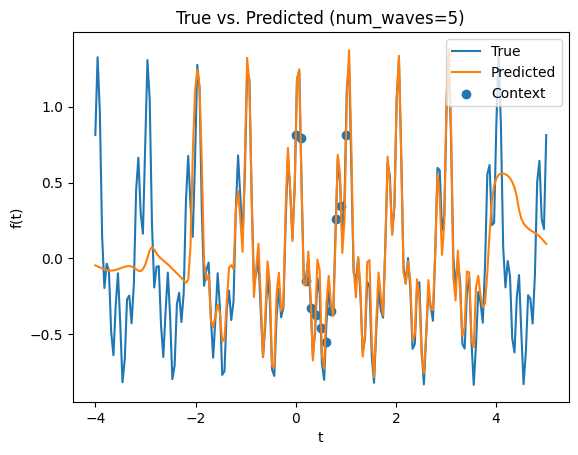

In [ ]:
cur_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen_comparison_graphs(cur_model, num_waves=5, device=device, query_start=-4, query_end=5)

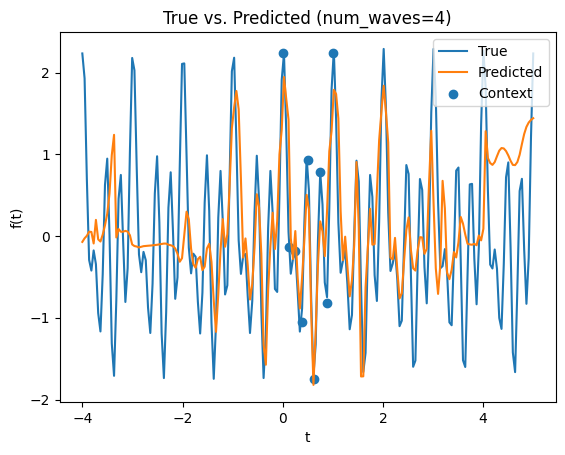

In [ ]:
sin_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen_comparison_graphs(sin_model, num_waves=4, device=device, query_start=-4, query_end=5)

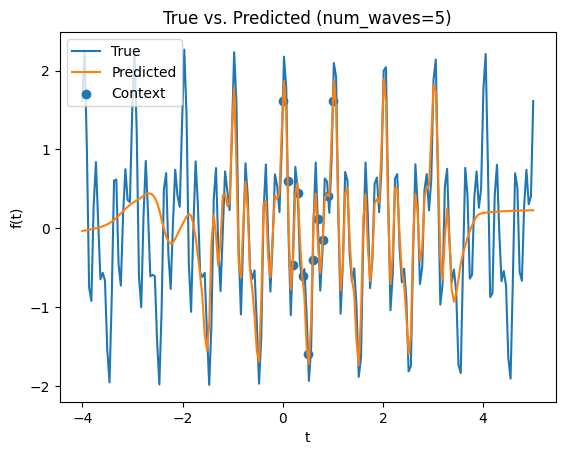

In [ ]:
cur_sin_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen_comparison_graphs(cur_sin_model, num_waves=5, device=device, query_start=-4, query_end=5)

In [ ]:
#@title Tools for Final Evaluations
import numpy as np
import matplotlib.pyplot as plt
import torch

def evaluate_n_examples(model, num_waves, num_examples=10, plot_graphs=True, device=None):
    """
    Generates comparison plots and computes MSE over three sub-intervals plus [0,3].

    Args:
        model:         GPT2Regressor in eval() mode
        num_waves:     number of sine components
        num_examples:  how many random functions to test
        plot_graphs:   whether to show each plot
        device:        torch device (defaults to model.device)
    """
    if device is None:
        device = next(model.parameters()).device

    all_mse = []
    for example_num in range(num_examples):
        # 1) Sample sine parameters
        freqs  = 2 * np.pi * np.arange(1, num_waves + 1)
        phases = np.random.choice([0, np.pi/2], size=num_waves)
        amps   = np.random.rand(num_waves)

        # 2) True function
        def f_true(t):
            out = np.zeros_like(t)
            for a, f, p in zip(amps, freqs, phases):
                out += a * np.sin(f * t + p)
            return out

        # 3) Context in [0,1]
        grid_len    = 2 * num_waves + 1
        context_ts  = np.linspace(0, 1, grid_len)
        np.random.shuffle(context_ts)
        context_fs  = f_true(context_ts)
        context     = list(zip(context_ts.tolist(), context_fs.tolist()))

        # 4) Dense queries
        query_ts = np.linspace(0, 3, 200)
        preds    = np.array([
            run_inference(model, context, float(t), device=device)
            for t in query_ts
        ])

        # 5) Plot if desired
        if plot_graphs:
            plt.figure()
            plt.plot(query_ts, f_true(query_ts), label='True')
            plt.plot(query_ts, preds,        label='Predicted')
            plt.scatter(context_ts, context_fs, label='Context')
            plt.title(f"True vs. Predicted (num_waves={num_waves}, example #{example_num})")
            plt.xlabel("t"); plt.ylabel("f(t)")
            plt.legend(); plt.show()

        # 6) Compute MSEs
        mse_intervals = []
        edges = np.linspace(0, 3, 4)  # 0, 1, 2, 3
        true_vals = f_true(query_ts)
        for start, end in zip(edges[:-1], edges[1:]):
            mask = (query_ts >= start) & (query_ts < end)
            mse_intervals.append(((preds[mask] - true_vals[mask])**2).mean())
        # full [0,3]
        mse_intervals.append(((preds - true_vals)**2).mean())

        all_mse.append(mse_intervals)

    all_mse = np.array(all_mse)
    print("Per-interval MSEs:\n", all_mse)
    print("Mean across all examples:", np.mean(all_mse, axis=0))
    return all_mse

# run with synchronous CUDA errors on
%env CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Change model to sin_model or sin_model to model depending on what you are running.
res = evaluate_n_examples(sin_model, num_waves=5, num_examples=150, device=device)

In [ ]:
#@title Tools for Generating Histograms
import matplotlib.pyplot as plt
# Define missing variables
global_min = np.min(res)
x_max = np.max(res)
x_step = 0.02
x_right = np.ceil(x_max / x_step) * x_step
titles = ["Histogram of MSE from 0-1", "Histogram of MSE from 1-2", "Histogram of MSE from 2-3", "Histogram of MSE over entire range"]

# Recalculate bins with new x_right
bins = np.arange(np.floor(global_min), x_right + x_step, x_step)

# Compute global max frequency for consistent y-axis limits
max_freq = 0
for i in range(4):
  counts, _ = np.histogram(res[:, i], bins=bins)
  max_freq = max(max_freq, counts.max())

# Plot histograms with all axes aligned
for i in range(4):
  plt.figure()
  plt.hist(res[:, i], bins=bins, edgecolor='white')
  plt.title(titles[i])
  plt.xlabel("MSE")
  plt.ylabel("Frequency")
  plt.ylim(0, max_freq)
  plt.xlim(bins[0], x_right)
  plt.xticks(np.arange(bins[0], x_right + 0.001, x_step))
  plt.tight_layout()
  plt.show()